# Importing libraries

In [9]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import re
import tqdm
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Scikit-learn dependencies ###
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

### nltk dependencies ###
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

### Download nltk data ###
!python3 -m nltk.downloader punkt
!python3 -m nltk.downloader stopwords
!python3 -m nltk.downloader wordnet

### Some constants ###
true_path = "/content/drive/My Drive/True.csv"
fake_path = "/content/drive/My Drive/Fake.csv"
glove_emb_file = '/content/drive/My Drive/glove.twitter.27B.100d.txt'

Mounted at /content/drive
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package word

# Loading and preprocessing text data

### Loading data

In [2]:
df_true = pd.read_csv(true_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))
df_fake = pd.read_csv(fake_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))

df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake])

df.head(10)

,title,text,subject,date,label
11211,Trump fans in Iowa cheer his debate performance,"WAUKEE, Iowa (Reuters) - It was not hard to te...",politicsNews,"January 15, 2016",1
18807,"UK business, unions ally to urge Brexit citize...",LONDON (Reuters) - Britain s leading business ...,worldnews,"September 28, 2017",1
20233,Average of polls puts New Zealand's ruling Nat...,WELLINGTON (Reuters) - New Zealand s ruling Na...,worldnews,"September 13, 2017",1
1568,House panel probing private email use by White...,WASHINGTON (Reuters) - A U.S. House of Represe...,politicsNews,"September 26, 2017",1
6289,"Unlike Trump, Americans want strong environmen...",NEW YORK (Reuters) - More than 60 percent of A...,politicsNews,"January 17, 2017",1
4360,China's Xi urges trade cooperation in first me...,"PALM BEACH, Fla. (Reuters) - Chinese President...",politicsNews,"April 6, 2017",1
2972,States' Medicaid spending to increase under Se...,NEW YORK (Reuters) - The now-delayed U.S. Sena...,politicsNews,"June 28, 2017",1
17744,Hezbollah dismisses U.S. rewards for arrest of...,BEIRUT (Reuters) - Lebanon s Hezbollah group d...,worldnews,"October 11, 2017",1
18134,Italy high court upholds four-year sentence on...,ROME (Reuters) - Italy s highest court on Frid...,worldnews,"October 6, 2017",1
20895,Germany says EU states must implement court ru...,BERLIN (Reuters) - German Foreign Minister Sig...,worldnews,"September 6, 2017",1


### Cleaning text data

In [3]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

stop_words = set(stopwords.words('english')) # Assuming all nltk data is installed
lemmatizer = WordNetLemmatizer()

def filter_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    filtered_sentence = ' '.join(filtered)

    ### Removing all special characters ###
    special_chars = ['…', '–', '’', '‘', '”', '“']

    for char_ in special_chars:
      filtered_sentence = filtered_sentence.replace(char_, "")

    # Removal of extra spaces
    filtered_sentence = re.sub(' +',' ',filtered_sentence)
    return filtered_sentence

def preprocessing_text(text):
  ### 1. Removing tags and accented data ###
  text = cleanhtml(text)
  text = remove_accents(text)

  ### 2. Expanding contractions ###
  text = expand_contractions(text)

  ### 3. Removing punctuations + lowercasing ###
  text = text.lower()
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

  ### 4. Removing special characters ### 
  #text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove non-text chars
  #text = re.sub(' +',' ',text) # Remove extra spaces
  #text = re.sub('\w*\d\w*','', text) # Remove digits
  
  ### 5. Lemmatization and stopwords removal ###
  text = filter_stopwords(text)

  return text

In [4]:
df['title'] = df['title'].apply(lambda x : preprocessing_text(x))
df['text']  = df['text'].apply(lambda x : preprocessing_text(x))
df['title'].head(10)

11211              trump fan iowa cheer debate performance
18807    uk business union ally urge brexit citizenship...
20233    average poll put new zealand ruling national a...
1568     house panel probing private email use white ho...
6289     unlike trump american want strong environmenta...
4360     china xi urge trade cooperation first meeting ...
2972     state medicaid spending increase senate bill r...
17744        hezbollah dismisses u reward arrest operative
18134    italy high court upholds fouryear sentence vet...
20895    germany say eu state must implement court ruli...
Name: title, dtype: object

# Feature engineering methods comparision

In [5]:
count_vec = CountVectorizer(min_df=5)
bi_count_vec = CountVectorizer(min_df=3, ngram_range=(1,2))
tf_idf_vec = TfidfVectorizer(min_df=5)

features_text = df['title'].values
targets = df['label'].values

### Using Bag-of-words ###
model = LogisticRegression()
features = count_vec.fit_transform(features_text).toarray()
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.33333)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
accuracy_bow = accuracy_score(y_val, predictions)
print(f'[INFO] Accuracy of logistic regression when using BOW : {accuracy_bow}')

### Using N-gram Bow ###
model = LogisticRegression()
features = bi_count_vec.fit_transform(features_text).toarray()
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.33333)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
accuracy_ngram = accuracy_score(y_val, predictions)
print(f'[INFO] Accuracy of logistic regression when using Ngram-BOW : {accuracy_ngram}')

### Using Tf-Idf ###
model = LogisticRegression()
features = tf_idf_vec.fit_transform(features_text).toarray()
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.33333)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
accuracy_tf_idf = accuracy_score(y_val, predictions)
print(f'[INFO] Accuracy of logistic regression when using BOW : {accuracy_tf_idf}')

[INFO] Accuracy of logistic regression when using BOW : 0.9250037498125093
[INFO] Accuracy of logistic regression when using Ngram-BOW : 0.9388030598470076
[INFO] Accuracy of logistic regression when using BOW : 0.9374531273436328


# Loading GloVe pretrain embedding

In [6]:
# Loading embedding as a dictionary
f = open(glove_emb_file, 'r').readlines()
word_emb = {}
vectors = []

print('[INFO] Loading word embeddings into dict...')
with tqdm.tqdm(total=len(f)) as pbar:
  for i in range(len(f)):
    elems = f[i].strip().split(' ')
    vec = np.array(elems[1:101], dtype=float)
    word_emb[elems[0]] = vec

    pbar.update(1)

  0%|          | 4160/1193514 [00:00<00:28, 41591.51it/s]

[INFO] Loading word embeddings into dict...


100%|██████████| 1193514/1193514 [00:27<00:00, 42832.00it/s]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65281 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65281 missing from current font.
  font.set_

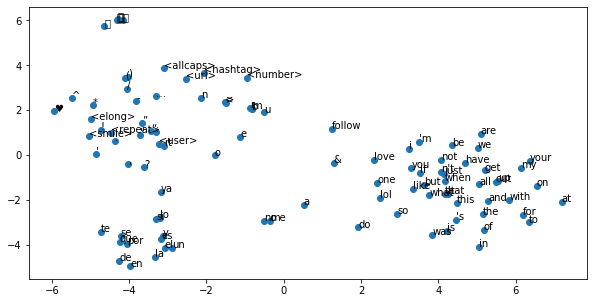

In [7]:
# Visualize some words in glove
tsne = TSNE(n_components=2)
keys = list(word_emb.keys()) 
vectors = []

fig, ax = plt.subplots(figsize=(10, 5))
for i in range(100):
  vector = word_emb[keys[i]]
  vectors.append(vector)

vectors = tsne.fit_transform(vectors)
ax.scatter(vectors[:,0], vectors[:,1])
for i in range(100):
  ax.annotate(keys[i], (vectors[:,0][i], vectors[:,1][i]))

plt.show()

# Building LSTM model with embedding

In [30]:
# Map words to integers
tokenizer = Tokenizer(char_level=False, oov_token='<None>')
tokenizer.fit_on_texts(features_text)
word_to_index = tokenizer.word_index 

features = pad_sequences(tokenizer.texts_to_sequences(features_text))
max_seq_len = features.shape[1]
emb_vector_len = word_emb['fuck'].shape[0]
vocab_size = np.max(features.flatten()) + 1

# construct embedding matrix that correspond with our training data
print('[INFO] Creating embedding matrix ... ')
emb_matrix = np.zeros((vocab_size, emb_vector_len))

with tqdm.tqdm(total=vocab_size) as pbar:
  for word, index in word_to_index.items():
    if(word in keys):
      emb_vector = word_emb[word]
      if(emb_vector is not None):
        emb_matrix[index, :] = emb_vector 

    pbar.update(1)


  1%|          | 144/16850 [00:00<00:11, 1439.46it/s]

[INFO] Creating embedding matrix ... 


100%|█████████▉| 16849/16850 [02:12<00:00, 127.36it/s]


In [35]:
# build the model with the embedding matrix created
def build_model(vocab_size, seq_len, emb_matrix, num_classes):
  inputs = Input(shape=(seq_len,))
  emb_layer = Embedding(vocab_size, 100, input_length=seq_len, weights=[emb_matrix], trainable=False)(inputs)

  rnn = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))(emb_layer)
  rnn = Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))(rnn)

  fc = Dense(128, activation='relu')(rnn)
  output = Dense(num_classes, activation='softmax')(fc)
  model = Model(inputs=inputs, outputs=output, name='SentimentAnalysis_GloVe')
  return model 

optimizer = Adam(lr=0.0001, beta_1=0.5, amsgrad=True)
model = build_model(vocab_size, max_seq_len, emb_matrix, 2)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "SentimentAnalysis_GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 28, 100)           1685000   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 28, 128)           84480     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 1,885,066
Trainable params: 200,066
Non-trainable params: 1,685,000
___________________________

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(features, df['label'].values, test_size=0.33333)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=64, epochs=10)

Epoch 1/10
209/209 [==============================] - 92s 393ms/step - loss: 0.5346 - accuracy: 0.7534 - val_loss: 0.2450 - val_accuracy: 0.8991
Epoch 2/10
209/209 [==============================] - 83s 396ms/step - loss: 0.2716 - accuracy: 0.8847 - val_loss: 0.2314 - val_accuracy: 0.9046
Epoch 3/10
209/209 [==============================] - 82s 392ms/step - loss: 0.2388 - accuracy: 0.9037 - val_loss: 0.2284 - val_accuracy: 0.9061
Epoch 4/10
209/209 [==============================] - 81s 388ms/step - loss: 0.2336 - accuracy: 0.9040 - val_loss: 0.1964 - val_accuracy: 0.9223
Epoch 5/10
209/209 [==============================] - 80s 381ms/step - loss: 0.2167 - accuracy: 0.9128 - val_loss: 0.1941 - val_accuracy: 0.9255
Epoch 6/10
209/209 [==============================] - 80s 383ms/step - loss: 0.2066 - accuracy: 0.9175 - val_loss: 0.1817 - val_accuracy: 0.9298
Epoch 7/10
209/209 [==============================] - 79s 377ms/step - loss: 0.2008 - accuracy: 0.9213 - val_loss: 0.1846 - val_ac

In [ ]:
### Visualization ###
loss, val_loss = history.history['loss'], history.history['val_loss']
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(loss, color='blue', label='Training Loss')
ax[0].plot(val_loss, color='orange', label='Validating Loss')
ax[1].plot(accuracy, color='blue', label='Training Accuracy')
ax[1].plot(val_accuracy, color='orange', label='Validating Accuracy')

ax[0].legend()
ax[1].legend()
plt.show()